In [1]:
!pip install ultralytics scikit-learn -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.0 MB/s eta 0:00:00


In [7]:
import json
from sklearn.model_selection import train_test_split
import os

# --- Configuration ---
# Ensure these paths match your uploaded files
input_json_path = '/content/JsonCoco.json'
output_dir = '/content/'
train_ratio = 0.8

# --- Splitting Script ---
with open(input_json_path, 'r') as f:
    coco_data = json.load(f)

images = coco_data['images']
annotations = coco_data['annotations']
categories = coco_data['categories']

train_images, val_images = train_test_split(images, train_size=train_ratio, shuffle=True, random_state=42)
train_image_ids = {img['id'] for img in train_images}
val_image_ids = {img['id'] for img in val_images}

train_annotations = [ann for ann in annotations if ann['image_id'] in train_image_ids]
val_annotations = [ann for ann in annotations if ann['image_id'] in val_image_ids]

train_coco = {"images": train_images, "annotations": train_annotations, "categories": categories}
val_coco = {"images": val_images, "annotations": val_annotations, "categories": categories}

train_output_path = os.path.join(output_dir, 'train.json')
val_output_path = os.path.join(output_dir, 'val.json')

with open(train_output_path, 'w') as f: json.dump(train_coco, f)
with open(val_output_path, 'w') as f: json.dump(val_coco, f)

print(f"Split complete! Saved to {train_output_path} and {val_output_path}")

Split complete! Saved to /content/train.json and /content/val.json


In [24]:
import yaml

# Load the existing dataset.yaml file
with open('dataset.yaml', 'r') as f:
    dataset_config = yaml.safe_load(f)

# Update the train and val keys
dataset_config['train'] = 'train/images/'
dataset_config['val'] = 'val/images/'

# Save the updated dictionary back to the dataset.yaml file
with open('dataset.yaml', 'w') as f:
    yaml.dump(dataset_config, f, default_flow_style=False)

print("dataset.yaml file updated successfully!")

dataset.yaml file updated successfully!


In [25]:
import os

base_dir = '/content/'

# Check if directories exist
train_images_dir = os.path.join(base_dir, 'train', 'images')
train_labels_dir = os.path.join(base_dir, 'train', 'labels')
val_images_dir = os.path.join(base_dir, 'val', 'images')
val_labels_dir = os.path.join(base_dir, 'val', 'labels')

print(f"Checking directory structure in {base_dir}:")
print(f"'{train_images_dir}' exists: {os.path.exists(train_images_dir)}")
print(f"'{train_labels_dir}' exists: {os.path.exists(train_labels_dir)}")
print(f"'{val_images_dir}' exists: {os.path.exists(val_images_dir)}")
print(f"'{val_labels_dir}' exists: {os.path.exists(val_labels_dir)}")

# Count files in each directory
print("\nCounting files:")
if os.path.exists(train_images_dir):
    print(f"Number of files in '{train_images_dir}': {len(os.listdir(train_images_dir))}")
else:
    print(f"'{train_images_dir}' does not exist, cannot count files.")

if os.path.exists(train_labels_dir):
    print(f"Number of files in '{train_labels_dir}': {len(os.listdir(train_labels_dir))}")
else:
    print(f"'{train_labels_dir}' does not exist, cannot count files.")

if os.path.exists(val_images_dir):
    print(f"Number of files in '{val_images_dir}': {len(os.listdir(val_images_dir))}")
else:
    print(f"'{val_images_dir}' does not exist, cannot count files.")

if os.path.exists(val_labels_dir):
    print(f"Number of files in '{val_labels_dir}': {len(os.listdir(val_labels_dir))}")
else:
    print(f"'{val_labels_dir}' does not exist, cannot count files.")

Checking directory structure in /content/:
'/content/train/images' exists: True
'/content/train/labels' exists: True
'/content/val/images' exists: True
'/content/val/labels' exists: True

Counting files:
Number of files in '/content/train/images': 93
Number of files in '/content/train/labels': 88
Number of files in '/content/val/images': 24
Number of files in '/content/val/labels': 22


In [32]:
import shutil
import os
import json # Need to load train_coco and val_coco again if not in scope

base_dir = '/content/'
label_source_dir = os.path.join(base_dir, 'Train', 'labels') # Assuming labels are in /content/Train/labels/

# Load train and validation data (if train_coco and val_coco are not in the current scope)
try:
    train_image_ids
    val_image_ids
except NameError:
    print("Loading train and val json files...")
    with open(os.path.join(base_dir, 'train.json'), 'r') as f:
        train_coco = json.load(f)
    with open(os.path.join(base_dir, 'val.json'), 'r') as f:
        val_coco = json.load(f)
    train_image_ids = {img['id'] for img in train_coco['images']}
    val_image_ids = {img['id'] for img in val_coco['images']}


for filename in os.listdir(label_source_dir):
    if filename.endswith('.txt'):
        image_filename_without_ext = os.path.splitext(filename)[0]
        src_path = os.path.join(label_source_dir, filename)

        # Find the corresponding image ID
        image_id = None
        # Search in both train and val images to find the image_id
        for img in train_coco['images'] + val_coco['images']:
            if os.path.splitext(img['file_name'])[0] == image_filename_without_ext:
                image_id = img['id']
                break

        if image_id is None:
            print(f"Warning: Image ID not found for label file {filename}. Skipping.")
            continue

        if image_id in train_image_ids:
            dest_path = os.path.join(base_dir, 'train', 'labels', filename)
            shutil.move(src_path, dest_path)
        elif image_id in val_image_ids:
            dest_path = os.path.join(base_dir, 'val', 'labels', filename)
            shutil.move(src_path, dest_path)
        else:
            print(f"Warning: Image ID {image_id} not found in either train or val sets. Skipping label file {filename}.")


print("Label files moved successfully to train/labels and val/labels.")

Label files moved successfully to train/labels and val/labels.


In [1]:
from ultralytics import YOLO

# Load a pre-trained YOLOv8 segmentation model
model = YOLO('yolov8n-seg.pt')

# Train the model using the dataset.yaml configuration file
results = model.train(
    data='dataset.yaml',
    epochs=100,
    imgsz=640,
    project='YOLOv8-Training',
    name='fine_tuning_run'
)

print("\n✅ Fine-tuning complete!")
print("Your trained model is saved in the 'YOLOv8-Training/fine_tuning_run/weights/' directory.")
print("The best performing model is named 'best.pt'.")

Ultralytics 8.3.203 🚀 Python-3.12.11 torch-2.8.0+cu126 CPU (Intel Xeon CPU @ 2.20GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n-seg.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=fine_tuning_run10, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pos

### Display Performance Metrics

The training results, including mAP scores, are saved in the `results.csv` file.

Displaying Mask PR curve from /content/YOLOv8-Training/fine_tuning_run10/MaskPR_curve.png


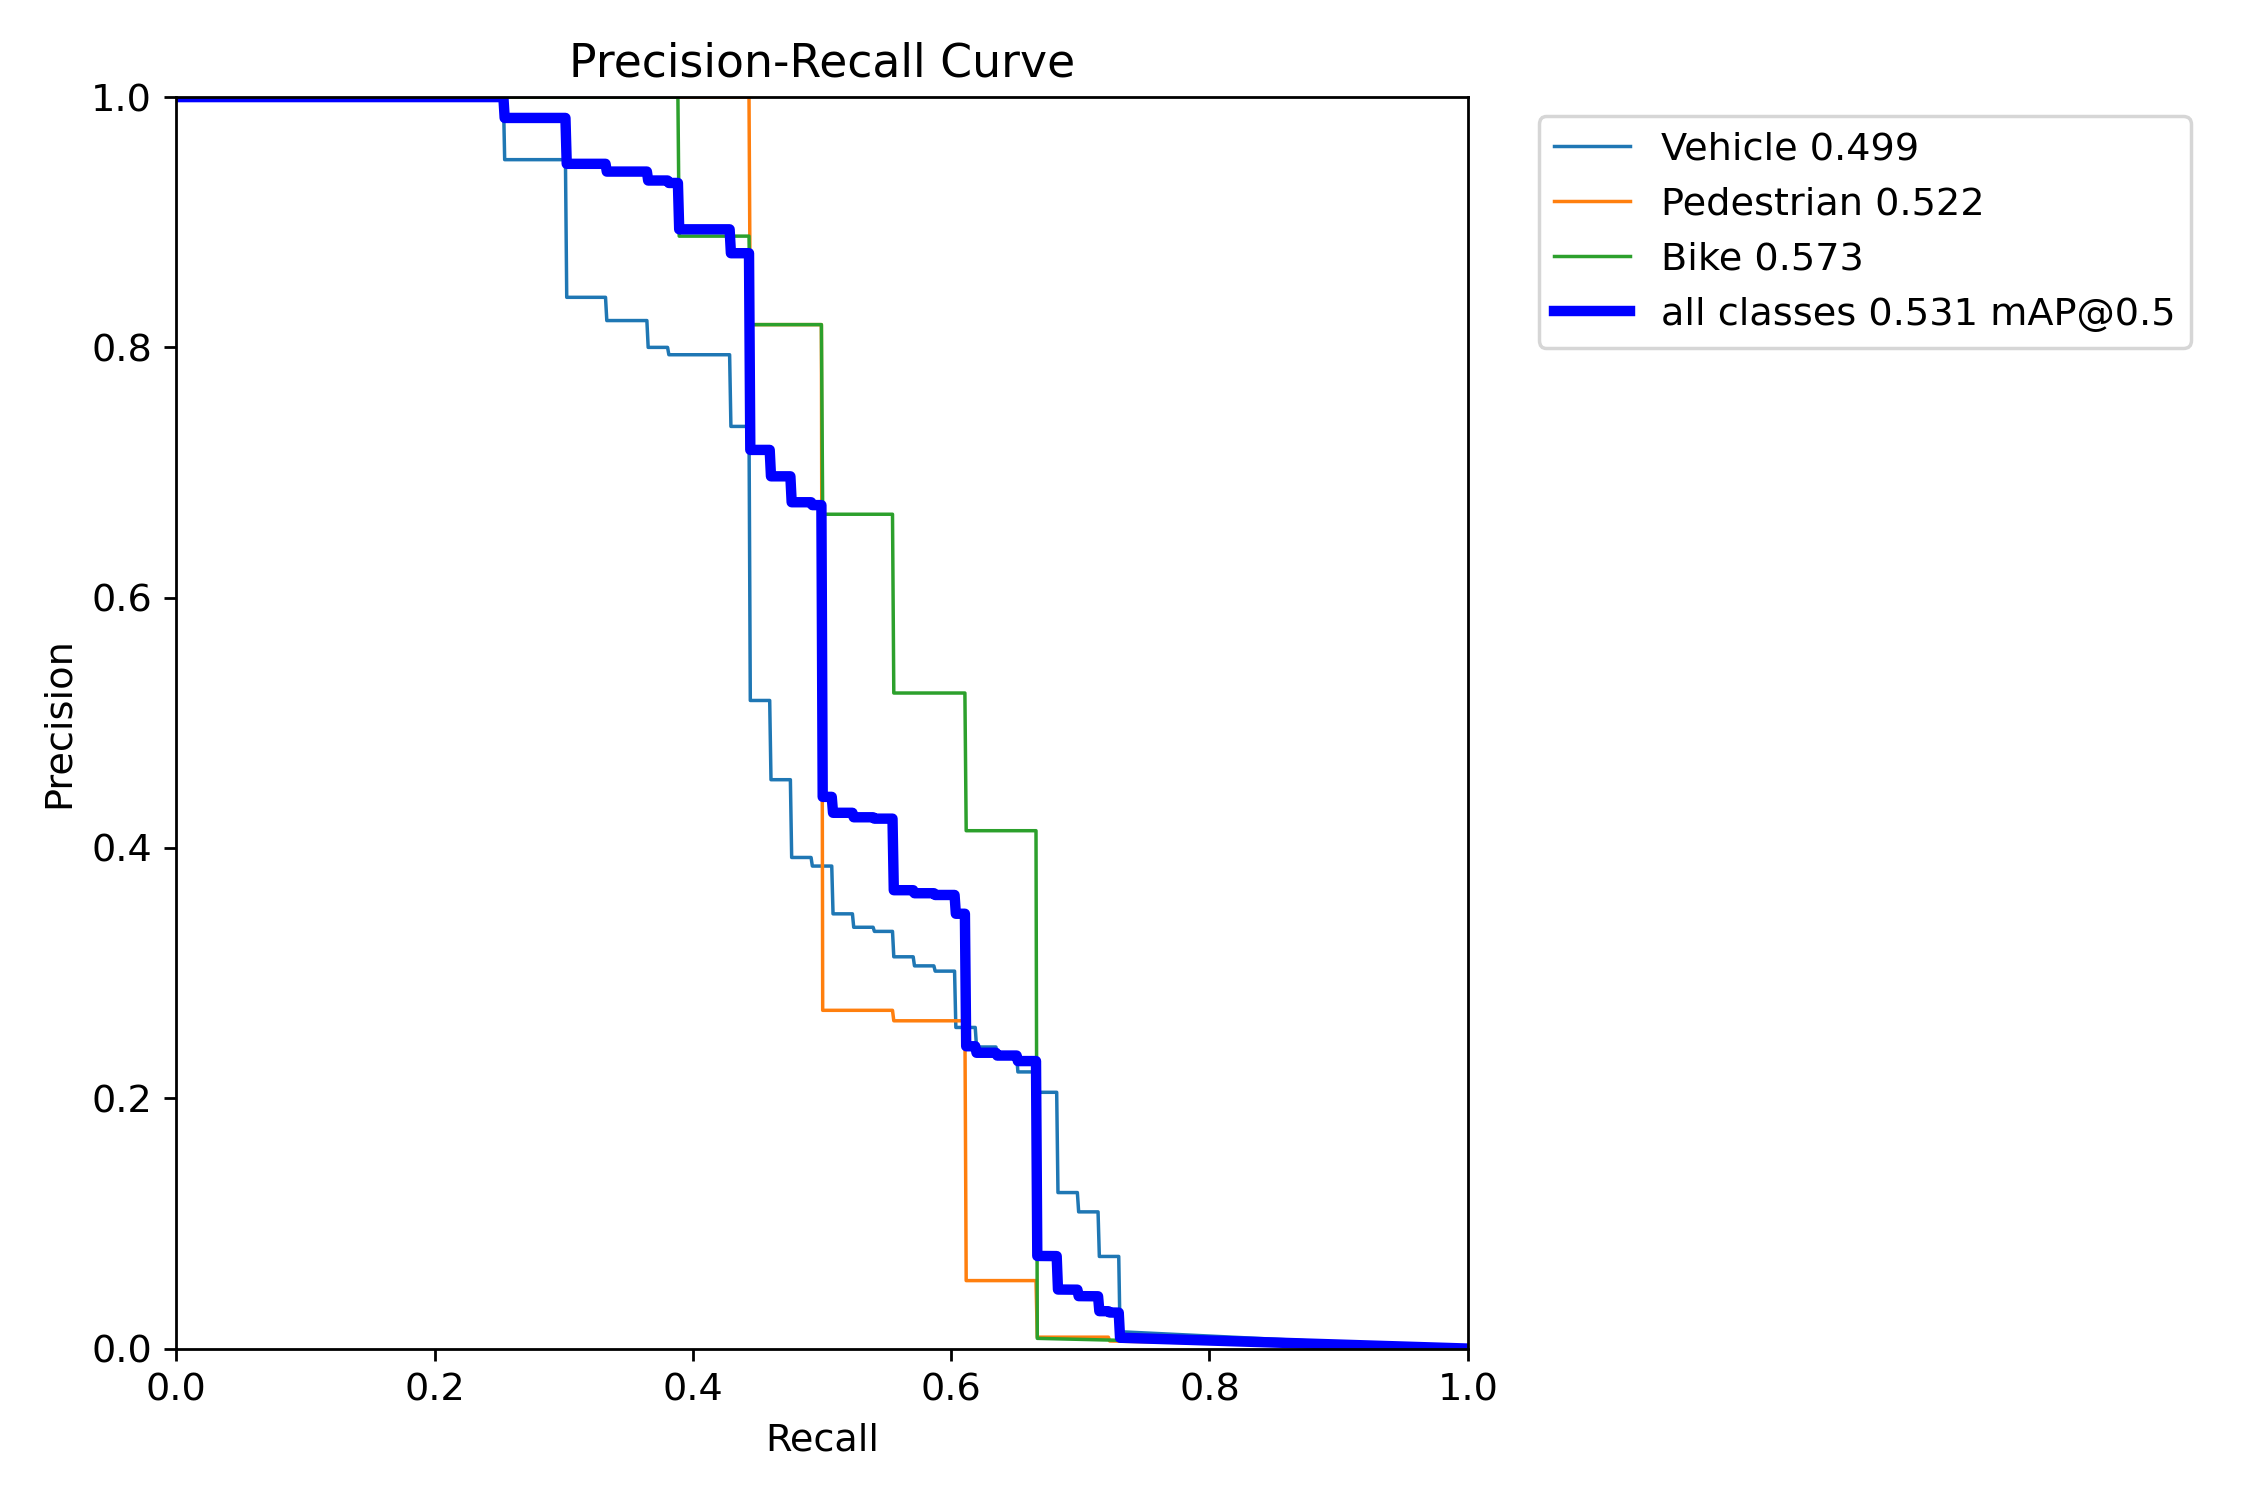

In [6]:
from IPython.display import Image, display
import os

# Update the path to point to the Mask PR curve
pr_curve_path = '/content/YOLOv8-Training/fine_tuning_run10/MaskPR_curve.png'

if os.path.exists(pr_curve_path):
    print(f"Displaying Mask PR curve from {pr_curve_path}")
    display(Image(filename=pr_curve_path))
else:
    print(f"Mask PR curve image not found at {pr_curve_path}")

In [7]:
# Assuming results_df from the previous cell is available
if 'results_df' in locals():
    # Get the last row of the DataFrame
    last_epoch_results = results_df.iloc[-1]

    # Extract the mAP50-95 values
    mAP50_95_box = last_epoch_results['metrics/mAP50-95(B)']
    mAP50_95_mask = last_epoch_results['metrics/mAP50-95(M)']

    print(f"Final mAP50-95 (Box): {mAP50_95_box:.4f}")
    print(f"Final mAP50-95 (Mask): {mAP50_95_mask:.4f}")
else:
    print("The results_df DataFrame was not found. Please run the cell to load results.csv first.")

Final mAP50-95 (Box): 0.3496
Final mAP50-95 (Mask): 0.2976


In [5]:
import os

results_dir = '/content/YOLOv8-Training/fine_tuning_run10/'

print(f"Listing files in: {results_dir}")
if os.path.exists(results_dir):
    for item in os.listdir(results_dir):
        print(item)
else:
    print(f"Directory not found: {results_dir}")

Listing files in: /content/YOLOv8-Training/fine_tuning_run10/
train_batch0.jpg
val_batch0_pred.jpg
MaskF1_curve.png
BoxR_curve.png
MaskPR_curve.png
labels.jpg
train_batch542.jpg
train_batch1.jpg
val_batch0_labels.jpg
confusion_matrix_normalized.png
MaskR_curve.png
MaskP_curve.png
confusion_matrix.png
BoxPR_curve.png
weights
BoxF1_curve.png
args.yaml
train_batch540.jpg
train_batch2.jpg
train_batch541.jpg
results.csv
results.png
BoxP_curve.png


In [2]:
import pandas as pd
import os

results_path = '/content/YOLOv8-Training/fine_tuning_run10/results.csv'

if os.path.exists(results_path):
    # Read the CSV, skipping the first line which is often commented out
    results_df = pd.read_csv(results_path)
    display(results_df)
else:
    print(f"Results file not found at {results_path}")

,epoch,time,train/box_loss,train/seg_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),...,metrics/recall(M),metrics/mAP50(M),metrics/mAP50-95(M),val/box_loss,val/seg_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,1,158.496,1.37795,2.46098,3.88143,1.16496,0.00401,0.24868,0.03573,0.01644,...,0.28836,0.03686,0.01678,1.15406,2.23978,3.99950,0.97241,0.000071,0.000071,0.000071
1,2,287.621,1.24007,2.12867,3.37547,1.08189,0.00759,0.33862,0.14234,0.10752,...,0.38624,0.14377,0.08939,1.14636,2.43229,3.92218,0.97353,0.000156,0.000156,0.000156
2,3,408.781,1.29182,2.04078,2.59450,1.07342,0.00889,0.38095,0.17050,0.10824,...,0.39947,0.16399,0.09852,1.25228,2.45538,3.87918,1.04671,0.000238,0.000238,0.000238
3,4,526.957,1.27260,2.06698,2.32213,1.05913,0.00620,0.29365,0.17246,0.11273,...,0.34127,0.17499,0.10272,1.30009,2.38067,3.85678,1.08019,0.000319,0.000319,0.000319
4,5,650.592,1.19029,1.98580,2.02944,1.02746,0.00554,0.34392,0.19109,0.12629,...,0.33069,0.17792,0.11358,1.34667,2.58297,3.82696,1.07421,0.000398,0.000398,0.000398
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,96,11425.800,0.67740,1.12463,0.79194,0.84152,0.69031,0.51846,0.55217,0.34891,...,0.41135,0.47882,0.28328,1.34850,2.86851,1.66306,1.15724,0.000085,0.000085,0.000085
96,97,11540.800,0.72864,1.14771,0.76821,0.87073,0.70207,0.51526,0.54988,0.34806,...,0.41412,0.47864,0.27926,1.35035,2.86578,1.65319,1.15906,0.000071,0.000071,0.000071
97,98,11657.400,0.69014,1.09412,0.75892,0.85444,0.69525,0.51720,0.54609,0.34807,...,0.42063,0.47652,0.29771,1.36035,2.85543,1.63340,1.16594,0.000057,0.000057,0.000057
98,99,11773.100,0.67794,1.04282,0.78224,0.84410,0.69715,0.51823,0.54738,0.34825,...,0.41534,0.47360,0.29319,1.36494,2.85784,1.61672,1.17037,0.000043,0.000043,0.000043
